In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

# generate fake data

In [2]:
# 390*60=60 days worth
n_data = 390 * 60

market_time = np.zeros((n_data,1))
stock_price = np.zeros((n_data,1))
stock_high = np.zeros((n_data,1))
stock_low = np.zeros((n_data,1))
stock_volume = np.zeros((n_data,1))

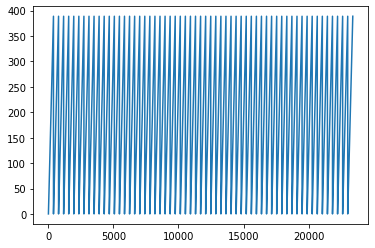

In [3]:
# market_time is in minutes, from 9:30 to 4pm, 390 minues
market_time[:,0] = np.mod(np.arange(n_data), 390)
plt.plot(market_time)

(0, 1000)

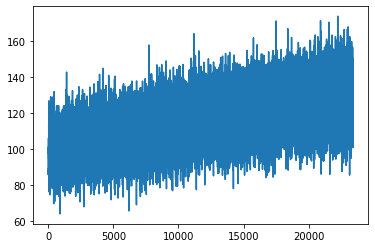

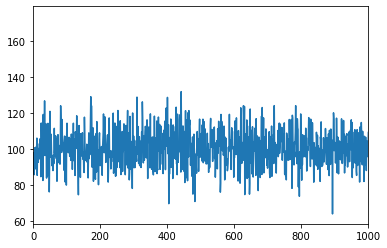

In [4]:
stock_price[:,0] = np.random.normal(100, 10, size=(n_data)) * (1 + np.arange(n_data)/n_data*0.3)
plt.plot(stock_price)
plt.figure()
plt.plot(stock_price)
plt.xlim(0,1000)

(0, 30)

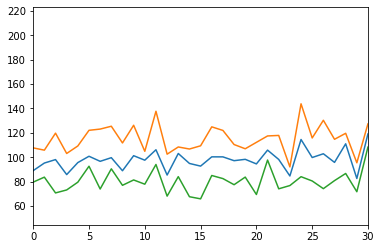

In [5]:
stock_high[:,0] = stock_price[:,0] * np.random.uniform(1.05, 1.3, size=(n_data))
stock_low[:,0] = stock_price[:,0] * np.random.uniform(0.95, 0.7, size=(n_data))
plt.plot(stock_price)
plt.plot(stock_high)
plt.plot(stock_low)
plt.xlim(0,30)

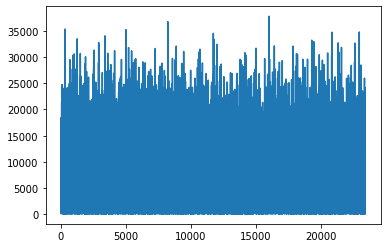

In [6]:
stock_volume[:,0] = np.maximum(np.random.normal(1000, 10000, size=(n_data)),0) + np.random.uniform(100, 1000, size=(n_data))
plt.plot(stock_volume)

# labeling data

In [7]:
# label as two numbers, first being buy, second being sell, -1 means error, 0 means no, 1 means yes
# exp: (0,1) means the price goes down in the future, so sell
# exp: (1,0) means the price goes up in the future, so buy
# exp: (0,0) means the price is stable in the future
# exp: (1,1) means the price fluctuates in the future

# look at the future prices between +future_1 minute and + future_2 minute, 
# if there are future price > current price * (1+thresh), than label it as buy
# if there are future price < current price * (1-thresh), than label it has sell

thresh = 0.25
future_1 = 10
future_2 = 100

stock_labels = np.ones((n_data,2)) * -1

for i in range (n_data-future_2):
    if np.max(stock_price[i+future_1:i+future_2],0) > stock_price[i,0]*(1+thresh):
        stock_labels[i,0] = 1
    else:
        stock_labels[i,0] = 0
        
    if np.min(stock_price[i+future_1:i+future_2],0) < stock_price[i,0]*(1-thresh):
        stock_labels[i,1] = 1
    else:
        stock_labels[i,1] = 0

(22700, 22750)

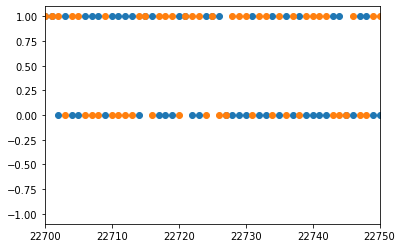

In [8]:
plt.plot(stock_labels[:,0],'o')
plt.plot(stock_labels[:,1],'o')
rand_range_start = np.random.randint(0,n_data-50)
plt.xlim(rand_range_start,rand_range_start+50)

# train and val data

In [9]:
# input: the previous 100 min of data
x_all = []
y_all = []
for i in range(100,n_data-future_2):
    x = np.concatenate((market_time[i-100:i], stock_price[i-100:i], stock_high[i-100:i], stock_low[i-100:i], stock_volume[i-100:i]), axis=1)
    x_all.append(x)
    y_all.append(stock_labels[i])
x_all = np.array(x_all)
y_all = np.array(y_all)

In [10]:
n_example = x_all.shape[0]
example_idxes = np.arange(n_example)
np.random.shuffle(example_idxes)
train_idxes = example_idxes[0:n_data*2//3]
val_idxes = example_idxes[n_data*2//3:]
print(x_all.shape, y_all.shape)
print(train_idxes.shape, val_idxes.shape)

(23200, 100, 5) (23200, 2)
(15600,) (7600,)


# simple ML model

In [11]:
import tensorflow as tf
import keras
from keras.models import Model, model_from_json
from keras.layers import Input, Flatten, Dense

from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [12]:
def buildModel(n_timepoint, n_features):
    a = Input(shape=(n_timepoint, n_features))
    
    b = Flatten()(a)
    b = Dense(128, activation='relu')(b)
    b = Dense(32, activation='relu')(b)

    c = Dense(2, activation='sigmoid')(b)
    model = Model(inputs=a, outputs=c)
    return model

In [13]:
model = buildModel(n_timepoint=100, n_features=5)
opt = keras.optimizers.Adam()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 5)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               64128     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 68,322
Trainable params: 68,322
Non-trainable params: 0
_________________________________________________________________


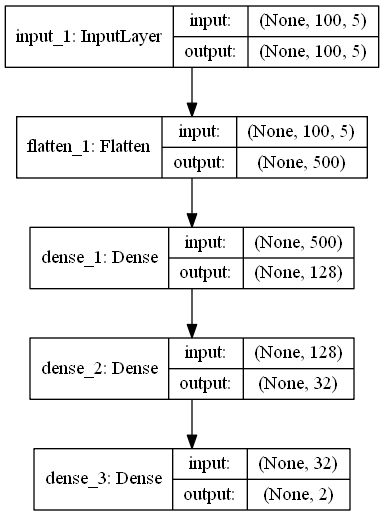

In [14]:
plot_model(model, show_shapes=True, show_layer_names=True)

# train model

In [15]:
history = model.fit(x=x_all[train_idxes], y=y_all[train_idxes], 
                    batch_size=1024, epochs=50, verbose=2, 
                    validation_data=(x_all[val_idxes], y_all[val_idxes]))

Train on 15600 samples, validate on 7600 samples
Epoch 1/50
 - 1s - loss: 672.8187 - accuracy: 0.5036 - val_loss: 349.9792 - val_accuracy: 0.5048
Epoch 2/50
 - 0s - loss: 230.2961 - accuracy: 0.5102 - val_loss: 107.5449 - val_accuracy: 0.5120
Epoch 3/50
 - 0s - loss: 44.5892 - accuracy: 0.5047 - val_loss: 4.4512 - val_accuracy: 0.4928
Epoch 4/50
 - 0s - loss: 2.0019 - accuracy: 0.4860 - val_loss: 0.9997 - val_accuracy: 0.4806
Epoch 5/50
 - 0s - loss: 0.8592 - accuracy: 0.4820 - val_loss: 0.8041 - val_accuracy: 0.4805
Epoch 6/50
 - 0s - loss: 0.7670 - accuracy: 0.4818 - val_loss: 0.7771 - val_accuracy: 0.4804
Epoch 7/50
 - 0s - loss: 0.7325 - accuracy: 0.4818 - val_loss: 0.7659 - val_accuracy: 0.4803
Epoch 8/50
 - 0s - loss: 0.7187 - accuracy: 0.4818 - val_loss: 0.7620 - val_accuracy: 0.4804
Epoch 9/50
 - 0s - loss: 0.7090 - accuracy: 0.4819 - val_loss: 0.7607 - val_accuracy: 0.4803
Epoch 10/50
 - 0s - loss: 0.7057 - accuracy: 0.4819 - val_loss: 0.7596 - val_accuracy: 0.4803
Epoch 11/50

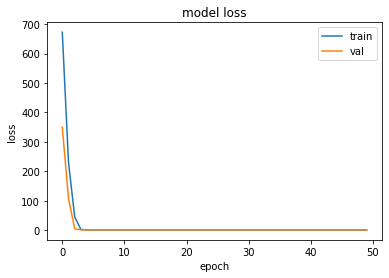

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

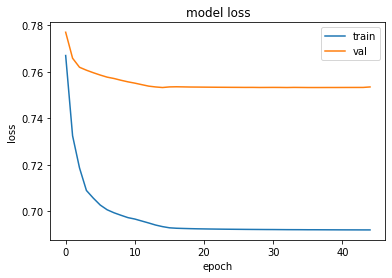

In [17]:
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

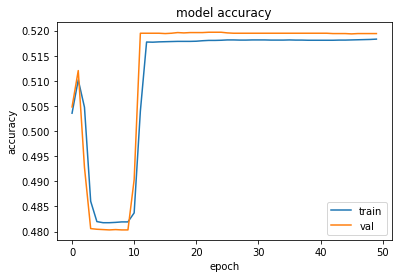

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# simulate on same data

In [19]:
init_stock_position = 0
init_cash = 10000

In [20]:
# strategy 1: buy all at time 0, sell all at the end
stock_position = init_cash / stock_price[0,0]
end_stock_value = stock_price[-future_2,0] * stock_position

print('Percent return:', end_stock_value / init_cash * 100 - 100)

Percent return: 37.08387372858118


In [21]:
# strategy 2: buy half, and then randomly buy and sell
percent_returns = []
for t in range(20):
    stock_position = init_cash / stock_price[0,0] / 2
    cash = init_cash / 2
    for i in range(n_data-future_2):
        action = np.random.randint(0,3)
        if action == 1:
            # buy one if you can
            if stock_price[i,0] < cash:
                stock_position += 1
                cash -= stock_price[i,0]
    #             print('bought 1 at', stock_price[i,0])
        elif action == 2:
            # sell one if you can
            if stock_position > 0:
                stock_position -= 1
                cash += stock_price[i,0]
    #             print('sold 1 at', stock_price[i,0])

    end_stock_value = stock_price[-future_2,0] * stock_position + cash
    print('Percent return:', end_stock_value / init_cash * 100 - 100)
    percent_returns.append(end_stock_value / init_cash * 100 - 100)
print('Average percent return:', np.average(percent_returns))

Percent return: 2.220379303231425
Percent return: 17.18438438422409
Percent return: -3.8418033137738803
Percent return: 19.62533539379801
Percent return: 7.4017044084843775
Percent return: 22.527469044746425
Percent return: 32.54870826135749
Percent return: 11.063283626774137
Percent return: 30.72473758893119
Percent return: 4.629226929258493
Percent return: 17.386394287245935
Percent return: 26.25562911769255
Percent return: 14.618465515781367
Percent return: -6.890099924445352
Percent return: 11.486353773007238
Percent return: 16.841299398260887
Percent return: 18.90043526098259
Percent return: -4.261581417068456
Percent return: 32.39667874993086
Percent return: 5.215266643572946
Average percent return: 13.801613351599617


In [22]:
# strategy 3: using the model, buy/sell as much as you can
stock_position = init_cash / stock_price[0,0] / 2
cash = init_cash / 2

actions = model.predict(x_all)

for i in range(100,n_data-future_2):
    if actions[i-100,0] > 0.5 and actions[i-100,1] < 0.5 and cash > 0:
        # buy as much as you can
        print('bought', cash / stock_price[i,0], 'at', stock_price[i,0])
        stock_position += cash / stock_price[i,0]
        cash = 0
    elif actions[i-100,0] < 0.5 and actions[i-100,1] > 0.5 and stock_position > 0:
        # sell as much as you can
        print('sold', stock_position, 'at', stock_price[i,0])
        cash += stock_price[i,0] * stock_position
        stock_position = 0

end_stock_value = stock_price[future_2,0] * stock_position + cash
print('Percent return:', end_stock_value / init_cash * 100 - 100)
percent_returns.append(end_stock_value / init_cash * 100 - 100)

sold 56.13530058376495 at 95.5371321652476
bought 91.5295007578398 at 113.220388456226
sold 91.5295007578398 at 109.76355115001644
bought 113.24711601394897 at 88.71398576658808
sold 113.24711601394897 at 118.41963746476148
bought 114.61026561828133 at 117.01118001913522
sold 114.61026561828133 at 133.48777057924102
bought 120.97704073573726 at 126.46258124546426
sold 120.97704073573726 at 130.96198202992318
bought 114.15874562153982 at 138.78387458277683
sold 114.15874562153982 at 143.67192465741937
Percent return: 64.01406699923373


In [23]:
# strategy 4: using the model, buy/sell 1
stock_position = init_cash / stock_price[0,0] / 2
cash = init_cash / 2

actions = model.predict(x_all)

for i in range(100,n_data-future_2):
    if actions[i-100,0] > 0.5 and actions[i-100,1] < 0.5 and cash > stock_price[i,0]:
        # buy 1
        print('bought 1 at', stock_price[i,0])  
        stock_position += 1
        cash -= stock_price[i,0]
    elif actions[i-100,0] < 0.5 and actions[i-100,1] > 0.5 and stock_position > 1:
        # sell 1
        print('sold 1 at', stock_price[i,0])
        stock_position -= 1
        cash += stock_price[i,0]

end_stock_value = stock_price[future_2,0] * stock_position + cash
print('Percent return:', end_stock_value / init_cash * 100 - 100)
percent_returns.append(end_stock_value / init_cash * 100 - 100)

sold 1 at 95.5371321652476
sold 1 at 107.23137352578475
bought 1 at 113.220388456226
sold 1 at 109.76355115001644
bought 1 at 88.71398576658808
bought 1 at 108.12839879785602
bought 1 at 82.4365834377471
bought 1 at 116.3128613700685
sold 1 at 118.41963746476148
sold 1 at 104.43869517912756
bought 1 at 117.01118001913522
bought 1 at 86.67925264564867
bought 1 at 132.40305349103411
bought 1 at 128.2727693184465
bought 1 at 117.31986382443546
bought 1 at 111.81072365062292
bought 1 at 115.13494460519162
bought 1 at 118.4075179294556
bought 1 at 118.88618964735211
bought 1 at 114.00103531324574
bought 1 at 139.85346750464296
bought 1 at 143.97003947253737
sold 1 at 133.48777057924102
bought 1 at 126.46258124546426
sold 1 at 130.96198202992318
bought 1 at 138.78387458277683
sold 1 at 143.67192465741937
Percent return: 9.982529035558315


# simulate on new data

In [24]:
# todo